In [1]:
import os 
os.chdir("./Kitsune/")
from netStat_torch import netStat
import AfterImage_torch as af

os.chdir("..")
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
import numpy as np
import matplotlib.pyplot as plt
import pickle
from utils import get_feature_map, load_data
from PytorchAD import AnomalyDetector
import time
import copy
from Kitsune.utils_torch import *
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm

In [2]:
# KitNET params
packages = load_data("data/mirai_packages.pkl")
maxAE = 10 #maximum size for any autoencoder in the ensemble layer
FMgrace = 5000 #the number of instances taken to learn the feature mapping (the ensemble's architecture)
ADgrace = 50000 #the number of instances used to train the anomaly detector (ensemble itself)

ratio_monitor = 0.05

FMgrace1 = int(FMgrace * ratio_monitor) #the number of instances taken to learn the feature mapping (the ensemble's architecture)
ADgrace1 = int(ADgrace * ratio_monitor) #the number of instances used to train the anomaly detector (ensemble itself)

np.random.seed(1234)
mirai_monitor_train_idx = np.sort(np.random.choice(range(FMgrace+ADgrace), 
                                                   size = int(ratio_monitor*(FMgrace+ADgrace)), 
                                                   replace=False))



In [3]:
mirai = load_data("data/mirai_vector.pkl")
AD = torch.load("model/AD_model.pt")
RMSE = np.array([0]*(FMgrace+ADgrace) + AD(mirai[FMgrace+ADgrace:]).tolist())
dos_attack_idx = np.where(RMSE>100)[0]
start_arp_idx = 120000

In [4]:

maxHost = 100000000000
maxSess = 100000000000
Lambdas = torch.tensor([5., 3., 1., .1, .01],dtype=torch.float64)
nstat_monitor = netStat(Lambdas, maxHost, maxSess)
mirai_monitor = []
t0 = time.time()
ts0 = packages[0][-1] # start timestamp
for i in range(len(packages)):
    if (i+1) % 10000 == 0:
        print("Finished {}. Time: {}s.".format(i+1, time.time()-t0))
        t0 = time.time()
        # pickle.dump(nstat, open("nstat_torch_save/FE_nosqrt_chkpt/nstat_idx_{}.pkl".format(i), "wb"))
    if i in dos_attack_idx or i == start_arp_idx:
        pickle.dump(nstat_monitor, open("nstat_torch_save/FE_attack_onlytrain0.05/nstat_idx_{}.pkl".format(i), "wb"))
        
    IPtype, srcMAC, dstMAC, srcIP, srcProtocol, dstIP, dstProtocol, datagramSize, timestamp = packages[i]
    if i in mirai_monitor_train_idx or srcMAC == '00:16:6c:7f:82:20' or dstMAC == '00:16:6c:7f:82:20':
        # the attacker only listens a small portion of packets and the packets related to attack MAC address.
        datagramSize = torch.tensor(datagramSize, dtype=torch.float64)
        timestamp = torch.tensor(timestamp - ts0, dtype=torch.float64) # due to lack of precision of torch.DoubleTensor 
        new_inst = nstat_monitor.updateGetStats(srcMAC, dstMAC, srcIP, srcProtocol, dstIP, dstProtocol, datagramSize, timestamp)
        mirai_monitor.append(new_inst.reshape(1,-1))
    

Finished 10000. Time: 6.0096142292022705s.
Finished 20000. Time: 13.265443086624146s.
Finished 30000. Time: 19.756470441818237s.
Finished 40000. Time: 25.949220418930054s.
Finished 50000. Time: 32.15173554420471s.
Finished 60000. Time: 37.00491809844971s.
Finished 70000. Time: 40.02984952926636s.
Finished 80000. Time: 47.221893548965454s.
Finished 90000. Time: 53.57035708427429s.
Finished 100000. Time: 59.89553451538086s.
Finished 110000. Time: 64.79110360145569s.
Finished 120000. Time: 69.25850701332092s.
Finished 130000. Time: 24.80722665786743s.
Finished 140000. Time: 10.614736557006836s.
Finished 150000. Time: 11.829412460327148s.
Finished 160000. Time: 8.48283863067627s.
Finished 170000. Time: 8.539078950881958s.
Finished 180000. Time: 14.33853530883789s.
Finished 190000. Time: 8.755417346954346s.
Finished 200000. Time: 8.476884603500366s.
Finished 210000. Time: 8.892071723937988s.
Finished 220000. Time: 8.974218606948853s.
Finished 230000. Time: 9.078021764755249s.
Finished 24000

In [5]:
mirai_monitor = torch.cat(mirai_monitor)
saveInputs = False
if saveInputs:
    pickle.dump(mirai_monitor, open("data/mirai_FEtorch_nosqrt_monitor{}.pkl".format(ratio_monitor), "wb"))
    

Train attacker's AD

In [6]:

# Train FM and initialize AD
v1 = get_feature_map(mirai_monitor.numpy(), FMgrace1, maxAE)
AD_monitor = AnomalyDetector(v1, device="cpu")

AD_monitor.eval()
AD_monitor_train_loss = []

train_AD_data = mirai_monitor[FMgrace1:FMgrace1+ADgrace1]

optimizer = SGD(AD_monitor.parameters(), lr=0.1)
AD_monitor.train()

t0 = time.time()
for i, x in enumerate(train_AD_data):
    if (i+1)%1000 == 0:
        print(i+1,"/",len(train_AD_data),", time: ",time.time()-t0,"s")
        t0 = time.time()
        
    z_list = AD_monitor(x.reshape(1,-1))
    optimizer.zero_grad()
    for i, error in enumerate(z_list):
        error.backward()
        optimizer.step()

    # record losss
    AD_monitor_train_loss.append(z_list[-1].item())



1000 / 2500 , time:  14.926737070083618 s
2000 / 2500 , time:  14.969923496246338 s


Print loss curve

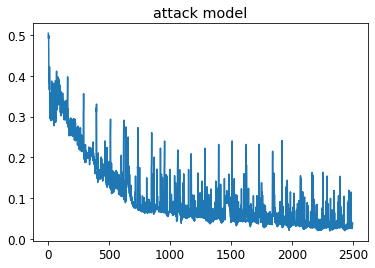

In [7]:
font = {'size':12}
matplotlib.rc('font', **font)
plt.plot(range(len(AD_monitor_train_loss)), AD_monitor_train_loss)
plt.title("attack model")
plt.show()

# Dos attack using monitor model

In [8]:
def testAdv(nstat, AD0, idx, max_iters=1000, th=1., item=[0,1], printInfo=True):
    '''
    test attack instance using FGSM
    '''
    Ptype, srcMAC, dstMAC, srcIP, srcProtocol, dstIP, dstProtocol, datagramSize, timestamp = packages[idx]
    datagramSize = torch.tensor(datagramSize, dtype=torch.float64).double()
    timestamp = torch.tensor(timestamp-ts0, dtype=torch.float64).double()
    
    datagramSize.requires_grad_(True)
    timestamp.requires_grad_(True)
    t0 = time.time()
    err_0 = 0
    err_f = -1
    for i in range(max_iters):
        
        new_inst = getStats(nstat, srcMAC, dstMAC, srcIP, srcProtocol, dstIP, dstProtocol, datagramSize, timestamp)
        res = AD0(new_inst.reshape(1, -1))
        if i == 0:
            # record initial error
            err_0 = res.item()
        if res < th:
            # lower than threshold
            err_f = res.item()
            break
        res.backward(retain_graph=True)
        # FGSM
        delta_ts, delta_ds = torch.sign(timestamp.grad), torch.sign(datagramSize.grad)
        
        with torch.no_grad():
            if 0 in item:
                timestamp -= 0.1*delta_ts
            if 1 in item:
                datagramSize -= 1.*delta_ds
        timestamp.requires_grad = True
        datagramSize.requires_grad = True
    if err_f < 0:
        err_f = res.item()
    if printInfo:
        print("{} ERROR: {:.2f} -> {:.2f}, delta_ts: {:.2f}, delta_ds: {}. Time: {:.2f}s".format(idx, err_0, err_f, 
                                                                                         timestamp.item()-packages[idx][-1] + ts0,
                                                                                         datagramSize.item()-packages[idx][-2],
                                                                                         time.time()-t0))
    return timestamp.item()-packages[idx][-1] + ts0, datagramSize.item()-packages[idx][-2]

In [9]:
monitor_attack_result = {}
AD_monitor.eval()
threshold_monitor = max(AD_monitor_train_loss)/ratio_monitor
success_num = 0
for idx in dos_attack_idx:
    nstat = pickle.load(open("nstat_torch_save/FE_attack_onlytrain0.05/nstat_idx_{}.pkl".format(idx), "rb"))
    nstat_org = pickle.load(open("nstat_torch_save/FE_nosqrt/nstat_idx_{}.pkl".format(idx), "rb"))
    try:
        delta_ts, delta_ds = testAdv(nstat, AD_monitor, idx, max_iters=1000, th=threshold_monitor, item=[1], printInfo=True)
        monitor_attack_result[idx] = (delta_ts, delta_ds)
        Ptype, srcMAC, dstMAC, srcIP, srcProtocol, dstIP, dstProtocol, datagramSize, timestamp = packages[idx]
        
        datagramSize = torch.tensor(datagramSize, dtype=torch.float64).double() + delta_ds
        timestamp = torch.tensor(timestamp-ts0, dtype=torch.float64).double() + delta_ts
        
        new_inst = getStats(nstat_org, srcMAC, dstMAC, srcIP, srcProtocol, dstIP, dstProtocol, datagramSize, timestamp)
        res = AD(new_inst.reshape(1, -1))
        if (res < threshold_monitor):
            success_num += 1
        else:
            print(idx, "not ok")
    except KeyError:
        print("keyerror")
print("{}/{} = {}".format(success_num,len(dos_attack_idx),success_num/len(dos_attack_idx)))

keyerror
keyerror
373052 ERROR: 7439070858.67 -> 0.02, delta_ts: 0.00, delta_ds: 7.0. Time: 0.61s
373542 ERROR: 4794095.94 -> 0.02, delta_ts: 0.00, delta_ds: 7.0. Time: 0.61s
374033 ERROR: 246693958.05 -> 0.02, delta_ts: 0.00, delta_ds: 7.0. Time: 0.58s
374256 ERROR: 535051655.98 -> 0.03, delta_ts: 0.00, delta_ds: -1.0. Time: 0.02s
374412 ERROR: 600789962.74 -> 0.02, delta_ts: 0.00, delta_ds: 7.0. Time: 0.58s
374677 ERROR: 78824141275.93 -> 0.55, delta_ts: 0.00, delta_ds: -1.0. Time: 0.02s
375181 ERROR: 55795741492.34 -> 0.19, delta_ts: 0.00, delta_ds: -1.0. Time: 0.02s
375729 ERROR: 10192028147.56 -> 0.03, delta_ts: 0.00, delta_ds: 1.0. Time: 0.02s
379494 ERROR: 4469617473.38 -> 0.02, delta_ts: 0.00, delta_ds: 7.0. Time: 0.59s
380072 ERROR: 2255076601.06 -> 0.03, delta_ts: 0.00, delta_ds: 7.0. Time: 0.09s
380519 ERROR: 1440288921.78 -> 0.02, delta_ts: 0.00, delta_ds: 7.0. Time: 0.59s
380692 ERROR: 5039675219.18 -> 0.04, delta_ts: 0.00, delta_ds: 1.0. Time: 0.03s
381187 ERROR: 10046508

# ARP scan attack

In [10]:

nstat = pickle.load(open("nstat_torch_save/FE_attack_onlytrain0.05/nstat_idx_{}.pkl".format(start_arp_idx), "rb"))

mean_delta_ts = []
max_mean_delta_ts = 100
for i in range(start_arp_idx, len(packages)):
    Ptype, srcMAC, dstMAC, srcIP, srcProtocol, dstIP, dstProtocol, datagramSize, timestamp = packages[i]
   
    datagramSize = torch.tensor(datagramSize, dtype=torch.float64).double()
    timestamp = torch.tensor(timestamp-ts0, dtype=torch.float64).double()
    if srcProtocol == 'arp' and srcMAC == '3c:33:00:98:ee:fd' and dstMAC == 'ff:ff:ff:ff:ff:ff':
        
        try:
            delta_ts, _ = testAdv(nstat, AD_monitor, i, max_iters=1000, th=threshold_monitor, item=[0], printInfo=True)
            mean_delta_ts.append(delta_ts)
            if len(mean_delta_ts) == max_mean_delta_ts:
                break
        except KeyError:
            pass
    
    new_inst = nstat.updateGetStats(srcMAC, dstMAC, srcIP, srcProtocol, dstIP, dstProtocol, datagramSize, timestamp)

delta_ts = np.mean(mean_delta_ts)
print(delta_ts)

122775 ERROR: 11.81 -> 10.03, delta_ts: 0.10, delta_ds: 0.0. Time: 0.02s
122867 ERROR: 7.06 -> 7.06, delta_ts: 0.00, delta_ds: 0.0. Time: 0.06s
122868 ERROR: 7.14 -> 7.14, delta_ts: 0.00, delta_ds: 0.0. Time: 0.00s
122869 ERROR: 7.24 -> 7.24, delta_ts: 0.00, delta_ds: 0.0. Time: 0.00s
122870 ERROR: 7.33 -> 7.33, delta_ts: 0.00, delta_ds: 0.0. Time: 0.00s
122872 ERROR: 7.41 -> 7.41, delta_ts: 0.00, delta_ds: 0.0. Time: 0.02s
122873 ERROR: 7.50 -> 7.50, delta_ts: 0.00, delta_ds: 0.0. Time: 0.00s
122874 ERROR: 7.60 -> 7.60, delta_ts: 0.00, delta_ds: 0.0. Time: 0.02s
122875 ERROR: 7.69 -> 7.69, delta_ts: 0.00, delta_ds: 0.0. Time: 0.01s
122876 ERROR: 7.78 -> 7.78, delta_ts: 0.00, delta_ds: 0.0. Time: 0.00s
122877 ERROR: 7.88 -> 7.88, delta_ts: 0.00, delta_ds: 0.0. Time: 0.02s
122878 ERROR: 7.97 -> 7.97, delta_ts: 0.00, delta_ds: 0.0. Time: 0.00s
122879 ERROR: 8.04 -> 8.04, delta_ts: 0.00, delta_ds: 0.0. Time: 0.02s
122880 ERROR: 8.14 -> 8.14, delta_ts: 0.00, delta_ds: 0.0. Time: 0.00s
1228

In [11]:
t_max = packages[-1][-1]
packages_without_arp = []
packages_arp = []
start_idx = 120000

# split arp and non-arp packets
for i, p in enumerate(packages):
    IPtype, srcMAC, dstMAC, srcIP, srcProtocol, dstIP, dstProtocol, datagramSize, timestamp = p
    
    if i > start_idx and srcProtocol == 'arp' and srcMAC == '3c:33:00:98:ee:fd' and dstMAC == 'ff:ff:ff:ff:ff:ff':
        packages_arp.append(p)
    else:
        packages_without_arp.append(p)

# modify arp packets' timestamp
arp_ts0 = packages_arp[0][-1]        
for i, p in enumerate(packages_arp):
    p[-1]=arp_ts0 + i*delta_ts

# merge
new_packages = packages_arp + packages_without_arp
new_packages = sorted(new_packages, key=lambda x:x[-1])

# don't pass the maximum of timestamp
j = 0
for j in range(len(new_packages)):
    if new_packages[j][-1]>t_max:
        break
new_packages = new_packages[:j]
len(new_packages)

225714

In [12]:

maxHost = 100000000000
maxSess = 100000000000
Lambdas = torch.tensor([5., 3., 1., .1, .01],dtype=torch.float64)
nstat_changed_arp = netStat(Lambdas, maxHost, maxSess)
mirai_changed_arp = []
t0 = time.time()
ts0 = new_packages[0][-1] # start timestamp
for i,p in enumerate(new_packages):
    if (i+1) % 10000 == 0:
        print("Finished {}. Time: {}s.".format(i+1, time.time()-t0))
        t0 = time.time()
        # pickle.dump(nstat, open("nstat_torch_save/FE_nosqrt_chkpt/nstat_idx_{}.pkl".format(i), "wb"))
    
    IPtype, srcMAC, dstMAC, srcIP, srcProtocol, dstIP, dstProtocol, datagramSize, timestamp = p
    datagramSize = torch.tensor(datagramSize, dtype=torch.float64)
    timestamp = torch.tensor(timestamp - ts0, dtype=torch.float64) # due to lack of precision of torch.DoubleTensor 
    new_inst = nstat_changed_arp.updateGetStats(srcMAC, dstMAC, srcIP, srcProtocol, dstIP, dstProtocol, datagramSize, timestamp)
    mirai_changed_arp.append(new_inst.reshape(1,-1))
    
mirai_changed_arp = torch.cat(mirai_changed_arp)


RMSEs_changed_arp = [0]*(FMgrace + ADgrace)+AD(mirai_changed_arp[FMgrace + ADgrace:]).tolist()

Finished 10000. Time: 34.590670585632324s.
Finished 20000. Time: 54.65930199623108s.
Finished 30000. Time: 74.39738011360168s.
Finished 40000. Time: 91.59377002716064s.
Finished 50000. Time: 111.29160833358765s.
Finished 60000. Time: 129.02664136886597s.
Finished 70000. Time: 140.1750569343567s.
Finished 80000. Time: 167.61911344528198s.
Finished 90000. Time: 182.7723433971405s.
Finished 100000. Time: 201.64598035812378s.
Finished 110000. Time: 225.03382205963135s.
Finished 120000. Time: 233.6212341785431s.
Finished 130000. Time: 233.3612368106842s.
Finished 140000. Time: 267.3918967247009s.
Finished 150000. Time: 276.40191531181335s.
Finished 160000. Time: 288.03233647346497s.
Finished 170000. Time: 298.13995599746704s.
Finished 180000. Time: 311.5701832771301s.
Finished 190000. Time: 310.05070519447327s.
Finished 200000. Time: 314.68432664871216s.
Finished 210000. Time: 316.43213295936584s.
Finished 220000. Time: 330.7879774570465s.


Plotting results


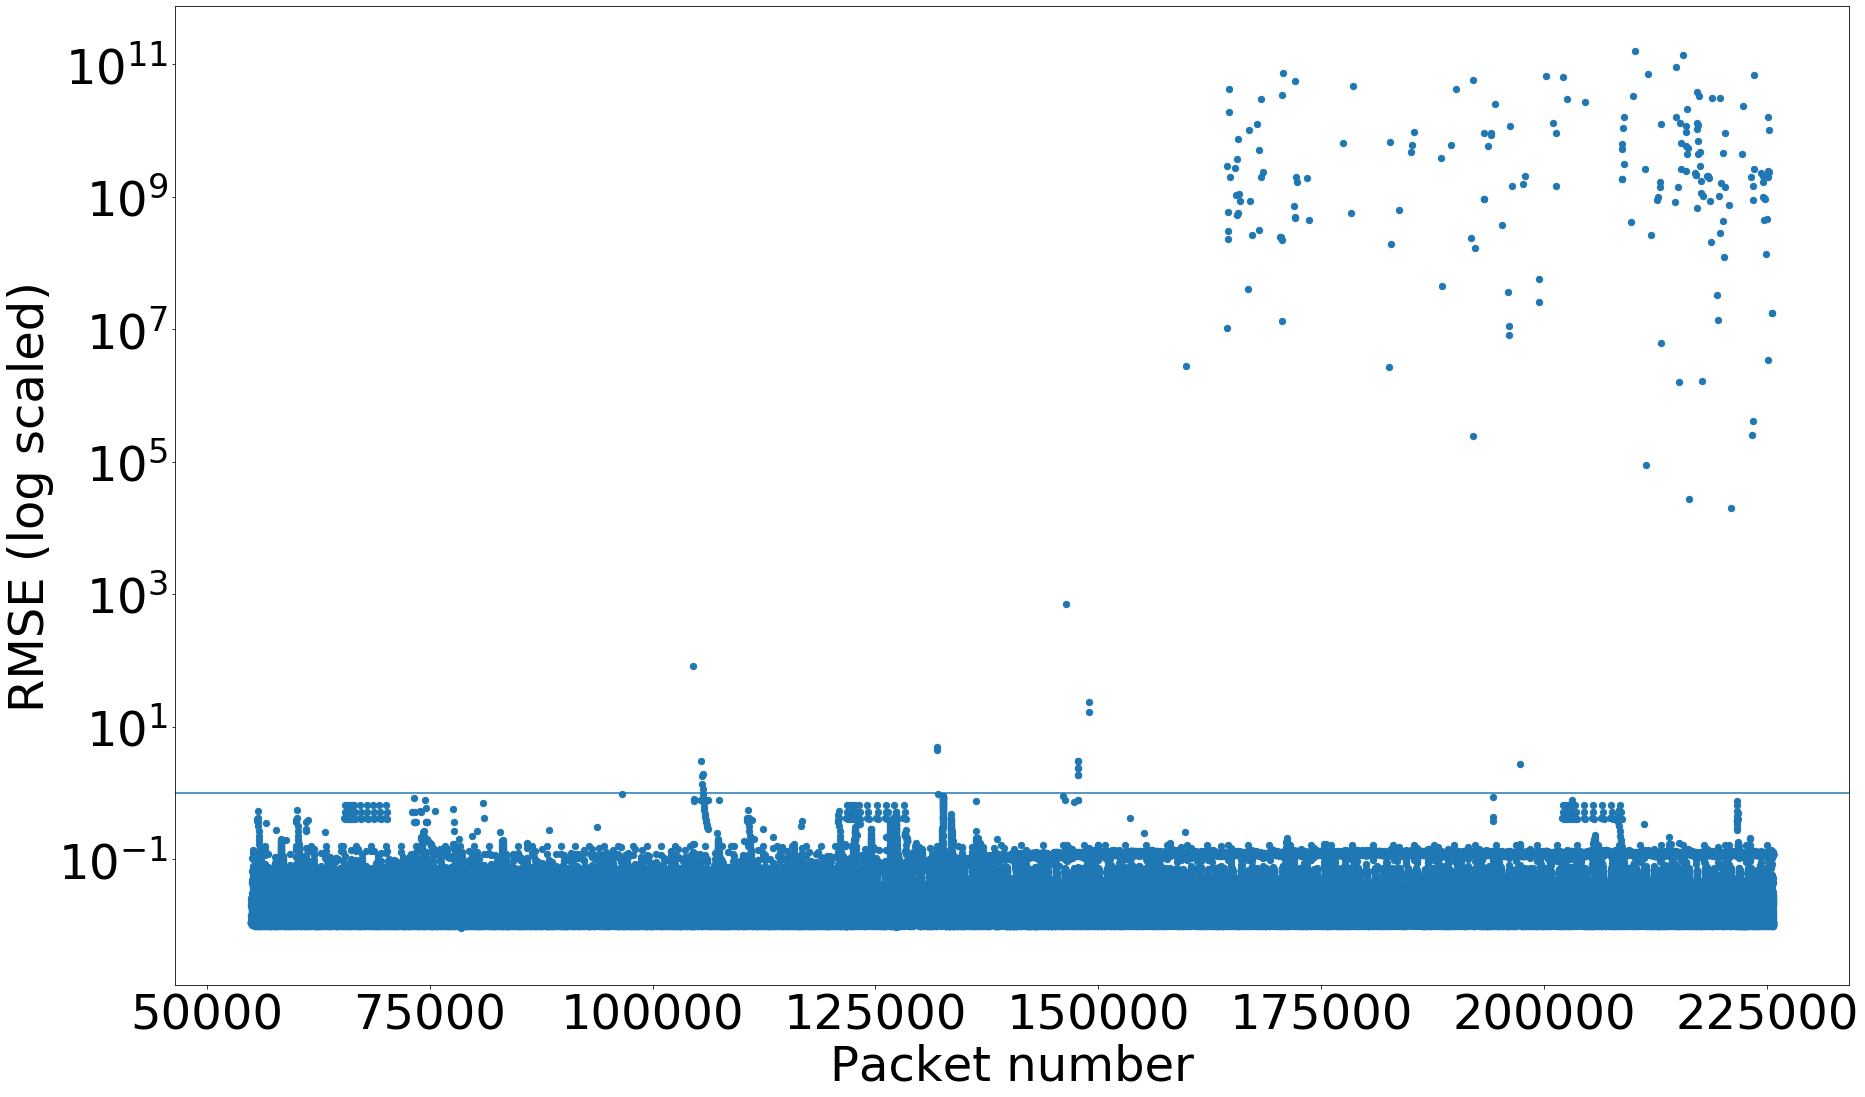

In [13]:
import matplotlib
# plot the RMSE anomaly scores
print("Plotting results")
from matplotlib import pyplot as plt
from matplotlib import cm
font = {'size':48}
matplotlib.rc('font', **font)
plt.figure(figsize=(30,18))
fig = plt.scatter(range(FMgrace+ADgrace,len(RMSEs_changed_arp)),RMSEs_changed_arp[FMgrace+ADgrace:],s=40)
plt.yscale("log")
#plt.title("Anomaly Scores from Kitsune's Execution Phase")
plt.ylabel("RMSE (log scaled)")
plt.xlabel("Packet number")
plt.axhline(y=1)
plt.show()

In [14]:
test_monitormodel_on_originvectors = False
if test_monitormodel_on_originvectors:
    RMSEs_monitor_on_org = [0]*(FMgrace+ADgrace) + AD_monitor(mirai[FMgrace+ADgrace:]).tolist()
    font = {'size':48}
    matplotlib.rc('font', **font)
    plt.figure(figsize=(30,18))
    fig = plt.scatter(range(FMgrace+ADgrace,len(RMSEs_monitor_on_org)),RMSEs_monitor_on_org[FMgrace+ADgrace:],s=40)
    plt.yscale("log")
    #plt.title("Anomaly Scores from Kitsune's Execution Phase")
    plt.ylabel("RMSE (log scaled)")
    plt.xlabel("Packet number")
    plt.axhline(y=100)
    plt.show()

In [15]:
arp_num = 0
suc_num = 0
for i,p in enumerate(new_packages):
    IPtype, srcMAC, dstMAC, srcIP, srcProtocol, dstIP, dstProtocol, datagramSize, timestamp = p
    if i > start_idx and srcProtocol == 'arp' and srcMAC == '3c:33:00:98:ee:fd' and dstMAC == 'ff:ff:ff:ff:ff:ff':
        arp_num += 1
        if RMSEs_changed_arp[i] < 1.0:
            suc_num += 1
print("{}/{}={}".format(suc_num, arp_num, suc_num/arp_num))

12544/12544=1.0
